<div style="background-color: #b3bdb5">
  <div style="padding: 20px; ">
    <h1 style="width: 100% ;color: black;font-weight: bold; text-align: center">Crop Damage Classification</h1>
  </div>
</div>

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Import Libraries</h4>
</div>

In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet101V2,InceptionResNetV2,MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,Average,Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
import seaborn as sns

<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">Data Preprocessng</h2>
  </div>
</div>

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Setting up directories</h4>
</div>

In [3]:
base_dir = '/kaggle/input/cdc5k-a-crop-damage-classification-image-dataset/CDC5k'  
train_dir = os.path.join(base_dir, 'Train Images')
test_dir = os.path.join(base_dir, 'Test Images')

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Creating instances for testing and training images</h4>
</div>

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Splitting Train and Validation Images from Train Images</h4>
</div>

In [5]:
train_dataset = []
for subdir in ['DR', 'G', 'WD']:
    current_dir = os.path.join(train_dir, subdir)
    for filename in os.listdir(current_dir):
        train_dataset.append((os.path.join(current_dir, filename), subdir))

# Convert to a dataframe
train_df = pd.DataFrame(train_dataset, columns=['filename', 'class'])

# 5% of the images used for validation
validation_size = 0.05 
num_validation_samples = int(validation_size * len(train_df))
train_df, validation_df = train_test_split(
    train_df,
    test_size=num_validation_samples,
    stratify=train_df['class'],
    random_state=42 
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Train, Test and Validation Data Generator</h4>
</div>

In [6]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 13680 validated image filenames belonging to 3 classes.
Found 720 validated image filenames belonging to 3 classes.
Found 600 images belonging to 3 classes.


<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">Creating Functions for Model Building and Result Analysis</h2>
  </div>
</div>

<div style="color: white ; background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Functions for Compilling and Fitting CNN Models</h4>
    <ul>
        <li>ResNet101V2 base model</li>
        <li>InceptionResNetV2 base model</li>
        <li>CNN Model</li>
        <li>Model Fitting</li>
    </ul>
</div>

In [53]:
def getResNet101V2(): 
    '''
    Returns: top model of ResNet101V2
    '''
    return ResNet101V2(weights='imagenet',
                         include_top=False,
                         input_shape=(150,150,3))
def getInceptionResNetV2(): 
    '''
    Return: top model of InceptionResNetV2
    '''
    return InceptionResNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(150,150,3))
def getMobileNet(): 
    '''
    Returns: top model of MobileNet
    '''
    return MobileNet(weights='imagenet',
                         include_top=False,
                         input_shape=(150,150,3))
def getModel(base_model,lr): 
    '''
    Input: 
        base_model: top model from keras.application
        lr: learning rate
    Return: compiled CNN model
    '''
    for layer in base_model.layers:
        layer.trainable = True

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    model.add(Dense(3, activation='softmax'))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
def runModel(model,epochs):
    '''
    Input: 
        model: CNN model
        epochs: number of itteration
    Return: model history
    '''
    return model.fit(train_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   epochs = epochs,
                   validation_data= validation_generator,
                   validation_steps=validation_generator.n//validation_generator.batch_size)

<div style="color: white ;background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Functions for Result Analysis</h4>
    <ul>
        <li>Plotting Accuracy and Loss</li>
        <li>Plotting Confusion Matrix</li>
    </ul>
</div>

In [8]:
def plotAccuracyAndLoss(history):
    '''
    Input: 
        history: receives model histor
    Output: plots accuracy and loss curve
    '''
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.legend(['Train','Validation'],loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train','Validation'],loc = 'upper left')
    plt.show()
def plotConfusionMatrix(model):
    '''
    Input: 
        model: receives model
    Output: predicts output using test images and plots confusion matrix
    '''

    test_loss, test_accuracy = model.evaluate(test_generator,
                               steps = test_generator.n/test_generator.batch_size)
    print(f"Test Loss :{test_loss}\nTest Accuracy :{test_accuracy}")
    model_predcitions = model.predict(test_generator,
                                   steps = test_generator.n/test_generator.batch_size)
    y_actual = test_generator.classes
    y_pred = np.argmax(model_predcitions, axis = 1)
    label_info = ["DR","G","WD"]
    cm = confusion_matrix(y_actual, y_pred)
    
    print("Classification Report:\n", classification_report(y_actual, y_pred, target_names=label_info))
    
    plt.figure(figsize = (10, 5))
    sns.heatmap(cm, annot = True, 
               fmt = "d", linewidths = 0.4,
               square = True,
               cmap = "Blues",
               xticklabels = label_info, 
               yticklabels = label_info)
    plt.xlabel("Actual Labels")
    plt.ylabel("Predcited labels")
    plt.title("Crop Damage Classifiction")
    plt.show()

<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">ResNet101V2</h2>
  </div>
</div>

In [14]:
lr = 0.001
epochs = 40

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Building and Compiling Model</h4>
</div>

In [15]:
modelResNet101V2 = getModel(getResNet101V2(),lr) #getting base model and passing it to getModel to receive compiled model
print(modelResNet101V2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 43677187 (166.62 MB)
Trainable params: 43579523 (166.24 MB)
Non-trainable params: 97664 (381.50 KB)
______

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Fitting Model</h4>
</div>

In [16]:
historyResNet101V2 = runModel(modelResNet101V2,epochs)

Epoch 1/40
427/427 [==============================] - 271s 496ms/step - loss: 0.9659 - accuracy: 0.5228 - val_loss: 1.4562 - val_accuracy: 0.4616
Epoch 2/40
427/427 [==============================] - 216s 506ms/step - loss: 0.8632 - accuracy: 0.5999 - val_loss: 1.2685 - val_accuracy: 0.4872
Epoch 3/40
427/427 [==============================] - 213s 498ms/step - loss: 0.8229 - accuracy: 0.6233 - val_loss: 0.9553 - val_accuracy: 0.5810
Epoch 4/40
427/427 [==============================] - 213s 498ms/step - loss: 0.8067 - accuracy: 0.6295 - val_loss: 0.8909 - val_accuracy: 0.6023
Epoch 5/40
427/427 [==============================] - 211s 494ms/step - loss: 0.7915 - accuracy: 0.6407 - val_loss: 0.8489 - val_accuracy: 0.6179
Epoch 6/40
427/427 [==============================] - 209s 489ms/step - loss: 0.7713 - accuracy: 0.6537 - val_loss: 1.0867 - val_accuracy: 0.5014
Epoch 7/40
427/427 [==============================] - 207s 483ms/step - loss: 0.7604 - accuracy: 0.6593 - val_loss: 1.4811 -

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Saving and Evaluating Model Using Test Images</h4>
</div>

In [17]:
modelResNet101V2.save('/kaggle/working/resnet101v2.h5')
model_evaluate = modelResNet101V2.evaluate(test_generator,
                               steps=test_generator.n//test_generator.batch_size)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 10s 552ms/step - loss: 0.7393 - accuracy: 0.6753


<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Result Analysis</h4>
</div>

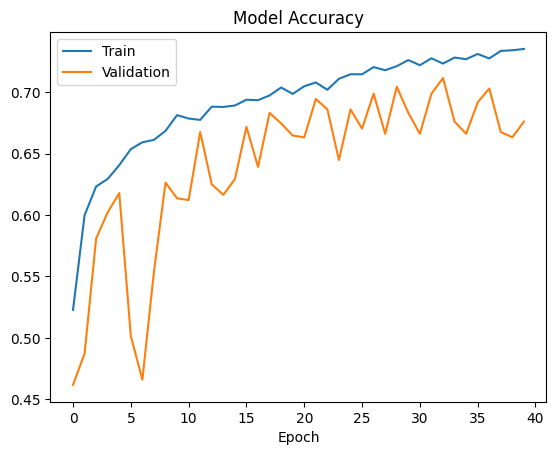

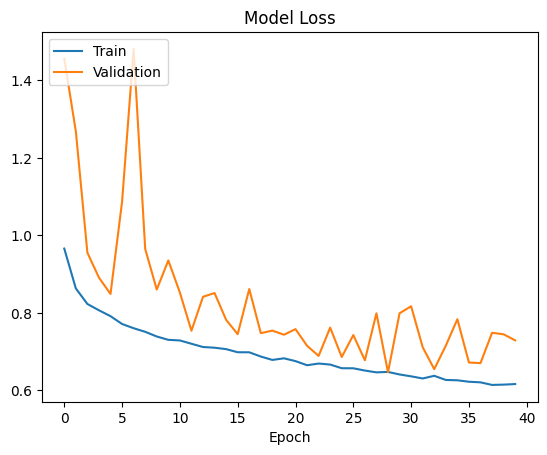

18/18 [==============================] - 8s 407ms/step - loss: 0.7461 - accuracy: 0.6783
Test Loss :0.7461205720901489
Test Accuracy :0.6783333420753479
18/18 [==============================] - 9s 379ms/step
Classification Report:
               precision    recall  f1-score   support

          DR       0.84      0.70      0.77       200
           G       0.65      0.63      0.64       200
          WD       0.59      0.70      0.64       200

    accuracy                           0.68       600
   macro avg       0.69      0.68      0.68       600
weighted avg       0.69      0.68      0.68       600



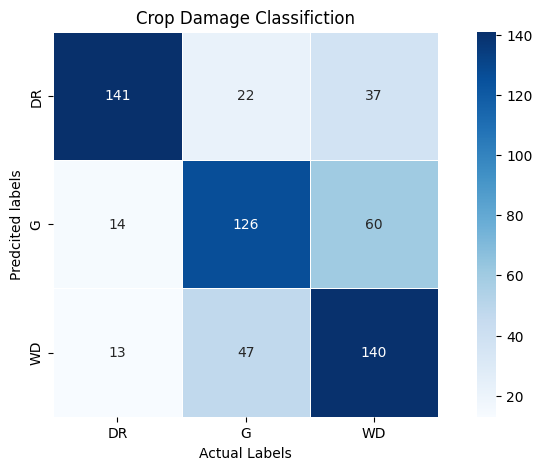

In [18]:
plotAccuracyAndLoss(historyResNet101V2)
plotConfusionMatrix(modelResNet101V2)

<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">InceptionResNetV2</h2>
  </div>
</div>

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Building and Compiling Model</h4>
</div>

In [19]:
modelInceptionResNetV2 = getModel(getInceptionResNetV2(),lr)
print(modelInceptionResNetV2.summary())

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 3, 3, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                     

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Fitting Model</h4>
</div>

In [20]:
historyInceptionResNetV2 = runModel(modelInceptionResNetV2,epochs)

Epoch 1/40
427/427 [==============================] - 293s 484ms/step - loss: 0.8636 - accuracy: 0.6103 - val_loss: 0.8125 - val_accuracy: 0.6179
Epoch 2/40
427/427 [==============================] - 204s 477ms/step - loss: 0.7643 - accuracy: 0.6591 - val_loss: 0.7972 - val_accuracy: 0.6420
Epoch 3/40
427/427 [==============================] - 206s 481ms/step - loss: 0.7428 - accuracy: 0.6726 - val_loss: 0.7219 - val_accuracy: 0.6605
Epoch 4/40
427/427 [==============================] - 206s 483ms/step - loss: 0.7127 - accuracy: 0.6851 - val_loss: 0.9465 - val_accuracy: 0.6065
Epoch 5/40
427/427 [==============================] - 205s 480ms/step - loss: 0.7023 - accuracy: 0.6888 - val_loss: 0.7127 - val_accuracy: 0.6534
Epoch 6/40
427/427 [==============================] - 205s 480ms/step - loss: 0.6897 - accuracy: 0.6964 - val_loss: 0.7459 - val_accuracy: 0.6662
Epoch 7/40
427/427 [==============================] - 205s 480ms/step - loss: 0.6857 - accuracy: 0.7031 - val_loss: 0.8640 -

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Saving and Evaluating Model Using Test Images</h4>
</div>

In [21]:
modelInceptionResNetV2.save('/kaggle/working/inceptionresnetv2.h5')
model_evaluate = modelInceptionResNetV2.evaluate(test_generator,
                               steps=test_generator.n//test_generator.batch_size)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 8s 431ms/step - loss: 0.8130 - accuracy: 0.6892


<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Result Analysis</h4>
</div>

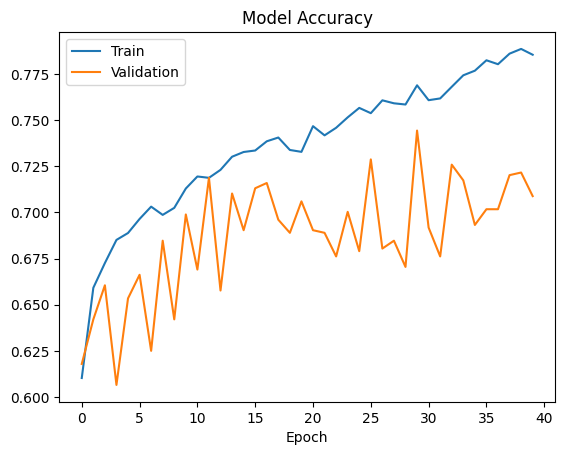

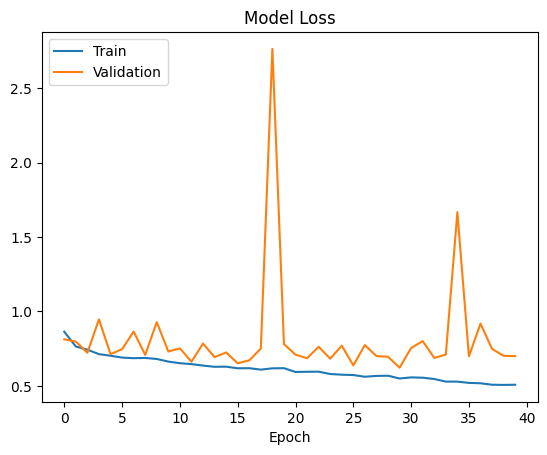

18/18 [==============================] - 8s 443ms/step - loss: 0.8012 - accuracy: 0.6933
Test Loss :0.8011739253997803
Test Accuracy :0.6933333277702332
18/18 [==============================] - 11s 401ms/step
Classification Report:
               precision    recall  f1-score   support

          DR       0.74      0.79      0.76       200
           G       0.72      0.57      0.64       200
          WD       0.63      0.72      0.67       200

    accuracy                           0.69       600
   macro avg       0.70      0.69      0.69       600
weighted avg       0.70      0.69      0.69       600



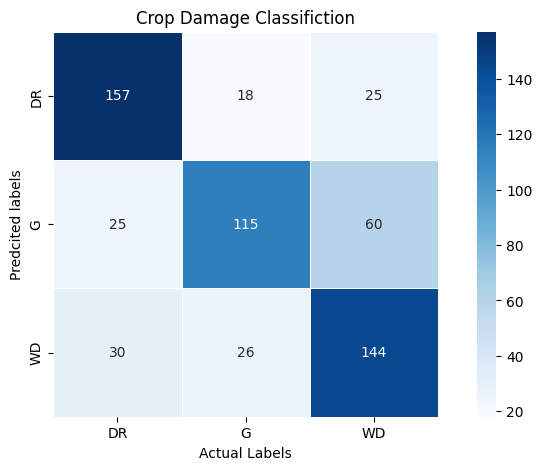

In [22]:
plotAccuracyAndLoss(historyInceptionResNetV2)
plotConfusionMatrix(modelInceptionResNetV2)

<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">MobileNet</h2>
  </div>
</div>

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Building and Compiling Model</h4>
</div>

In [54]:
modelMobileNet = getModel(getMobileNet(),lr) #getting base model and passing it to getModel to receive compiled model
print(modelMobileNet.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 3755203 (14.32 MB)
Trainable params: 373

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Fitting Model</h4>
</div>

In [55]:
historyMobileNet = runModel(modelMobileNet,8)

Epoch 1/8
427/427 [==============================] - 228s 501ms/step - loss: 0.8715 - accuracy: 0.6201 - val_loss: 0.7487 - val_accuracy: 0.6562
Epoch 2/8
427/427 [==============================] - 214s 500ms/step - loss: 0.7185 - accuracy: 0.6881 - val_loss: 1.0354 - val_accuracy: 0.6009
Epoch 3/8
427/427 [==============================] - 212s 497ms/step - loss: 0.6940 - accuracy: 0.6987 - val_loss: 0.7276 - val_accuracy: 0.6974
Epoch 4/8
427/427 [==============================] - 213s 500ms/step - loss: 0.6786 - accuracy: 0.7041 - val_loss: 0.7099 - val_accuracy: 0.7003
Epoch 5/8
427/427 [==============================] - 214s 501ms/step - loss: 0.6699 - accuracy: 0.7131 - val_loss: 0.6661 - val_accuracy: 0.7273
Epoch 6/8
427/427 [==============================] - 213s 499ms/step - loss: 0.6528 - accuracy: 0.7230 - val_loss: 0.7089 - val_accuracy: 0.6875
Epoch 7/8
427/427 [==============================] - 214s 501ms/step - loss: 0.6506 - accuracy: 0.7210 - val_loss: 0.6313 - val_ac

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Saving and Evaluating Model Using Test Images</h4>
</div>

In [56]:
modelMobileNet.save('/kaggle/working/mobilenet.h5')
model_evaluate = modelMobileNet.evaluate(test_generator,
                               steps=test_generator.n//test_generator.batch_size)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 8s 433ms/step - loss: 0.9150 - accuracy: 0.6111


<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Result Analysis</h4>
</div>

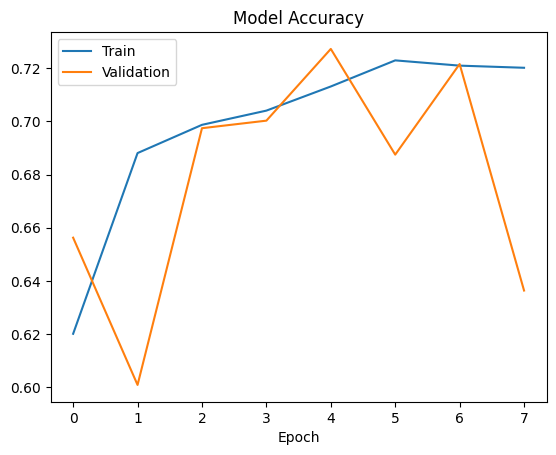

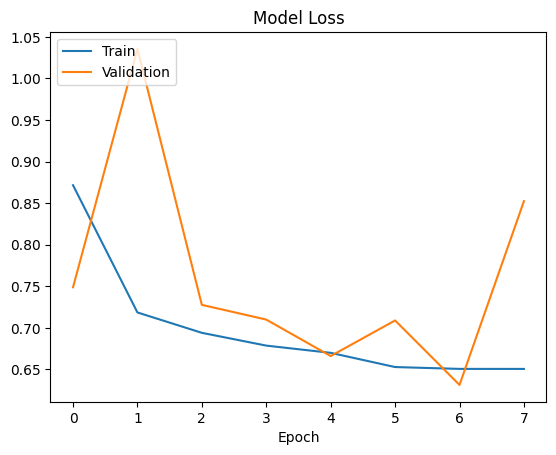

18/18 [==============================] - 8s 416ms/step - loss: 0.8899 - accuracy: 0.6233
Test Loss :0.8898774981498718
Test Accuracy :0.6233333349227905
18/18 [==============================] - 8s 402ms/step
Classification Report:
               precision    recall  f1-score   support

          DR       0.86      0.55      0.67       200
           G       0.83      0.39      0.53       200
          WD       0.49      0.94      0.65       200

    accuracy                           0.62       600
   macro avg       0.73      0.62      0.61       600
weighted avg       0.73      0.62      0.61       600



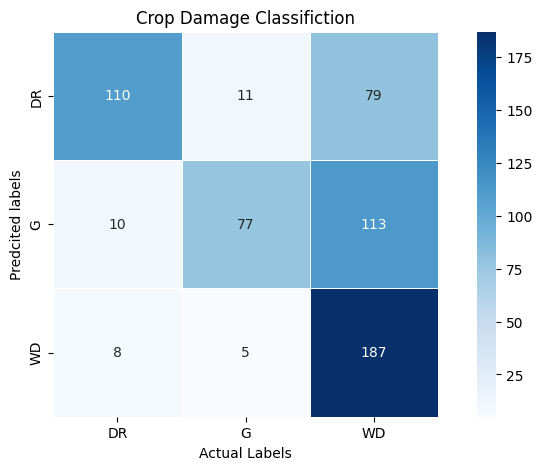

In [57]:
plotAccuracyAndLoss(historyMobileNet)
plotConfusionMatrix(modelMobileNet)

<div style="background-color: #3c314f">
  <div style="padding: 10px;">
    <h2 style="width: 100% ;color: white;font-weight: bold; text-align: center">Ensemble Learning Approch</h2>
  </div>
</div>

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Generating Ensemble Model</h4>
</div>

In [58]:
models = [modelResNet101V2,modelInceptionResNetV2,modelMobileNet]
model_input = Input(shape=(150,150,3))
model_outputs = [model(model_input) for model in models]
ensemble_outputs = Average()(model_outputs) #can try max
modelEnsemble = Model(inputs = model_input,outputs = ensemble_outputs)
modelEnsemble.compile(optimizer=Adam(learning_rate=lr), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
modelEnsemble.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 3)                    4367718   ['input_14[0][0]']            
                                                          7                                       
                                                                                                  
 sequential_2 (Sequential)   (None, 3)                    5512521   ['input_14[0][0]']            
                                                          9                                       
                                                                                            

<div style="background-color:#640b87; width: 50%; border: 1px solid #975df5 ;border-radius: 10px;padding:0px">
    <h4 style="color: white ;font-weight: bold; padding: 20px;padding-top: 6px; padding-bottom: 6px;">Fitting Model</h4>
</div>

In [59]:
historyEnsemble = runModel(modelEnsemble,5)

Epoch 1/5
427/427 [==============================] - 409s 551ms/step - loss: 0.5572 - accuracy: 0.7678 - val_loss: 0.7499 - val_accuracy: 0.7088
Epoch 2/5
427/427 [==============================] - 232s 544ms/step - loss: 0.5577 - accuracy: 0.7649 - val_loss: 0.7243 - val_accuracy: 0.7173
Epoch 3/5
427/427 [==============================] - 230s 537ms/step - loss: 0.5454 - accuracy: 0.7691 - val_loss: 0.7488 - val_accuracy: 0.6889
Epoch 4/5
427/427 [==============================] - 231s 540ms/step - loss: 0.5439 - accuracy: 0.7713 - val_loss: 0.6778 - val_accuracy: 0.6974
Epoch 5/5
427/427 [==============================] - 231s 540ms/step - loss: 0.5413 - accuracy: 0.7704 - val_loss: 0.6911 - val_accuracy: 0.7131
